# Evaluation of our final models

## Includes: 
- 4 Models: standard finetuning, 3 Layers trained, 6 Layers trained, Full model trained

# First Evaluation: 
## --> Translation 
- 3 Translation datasets: Training data, testing data long, testing data short
- The tree trained models should be compared

        

In [1]:
# Set the GPU for training
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'

In [2]:
import torch
import pickle
from transformers import GPT2Tokenizer, GPT2LMHeadModel, modeling_utils, GPT2Config, modeling_gpt2, GPT2Model, GPT2PreTrainedModel, GPT2Config
import copy
import operator
import json
import numpy as np
import pandas as pd
import language_check
from functools import reduce
import difflib
import matplotlib.pyplot as plt

In [4]:
def finetuned(path):
    model = GPT2LMHeadModel.from_pretrained('gpt2')
    model.load_state_dict(torch.load("transformers/examples/model_save/" + str(path)))
    return model

In [5]:
def split_train_2(train_data):
    continueSet = []
    target = []
    for x in range(len(train_data)):
        train_data[x] = train_data[x].split("====")
        if len(train_data[x]) != 3:
            pass
        else:
            continueSet.append(train_data[x][0] + "====" + train_data[x][1] + "====")
            target.append(train_data[x][2])
    return [continueSet,target]

In [6]:
def format_sentence_2(sentence):
    sentence = sentence.replace("<|endoftext|>","")
    if len(sentence) > 0:
        while sentence[0] == " " or sentence[0] == "\n":
            sentence = sentence[1:]
            if len(sentence) == 0:
                break
    if len(sentence) > 0:
        while sentence[-1] == " "  or sentence[-1] == "\n":
            sentence = sentence[:-1]
            if len(sentence) == 0:
                break
    return sentence

In [7]:
def levenshtein(seq1, seq2):
    size_x = len(seq1) + 1
    size_y = len(seq2) + 1
    matrix = np.zeros ((size_x, size_y))
    for x in range(size_x):
        matrix [x, 0] = x
    for y in range(size_y):
        matrix [0, y] = y

    for x in range(1, size_x):
        for y in range(1, size_y):
            if seq1[x-1] == seq2[y-1]:
                matrix [x,y] = min(
                    matrix[x-1, y] + 1,
                    matrix[x-1, y-1],
                    matrix[x, y-1] + 1
                )
            else:
                matrix [x,y] = min(
                    matrix[x-1,y] + 1,
                    matrix[x-1,y-1] + 1,
                    matrix[x,y-1] + 1
                )
    return (matrix[size_x - 1, size_y - 1])

In [8]:
def load_dream_6_test(nr):
    translations = []
    for x in range(1,nr+1):
        t1 = pickle.load(open("transformers/examples/6_layer_" + str(x) + "_T.p","rb"))
        translations.append(t1)

    train2 = open("transformers/examples/data_files/EOS_new_test.txt","r+",encoding="utf-8")
    train2 = train2.read()
    train2 = train2.split("<|endoftext|>")
    train2 = split_train_2(train2)
    out = {}
    out["input"] = [None,train2[0]]
    out["real"] = [None,train2[1]]
    out["translation"] = translations
    return out 

In [9]:
def load_dream_6_train(nr):
    translations = []
    for x in range(6,10):
        t1 = pickle.load(open("transformers/examples/6_layer_" + str(x) + ".p","rb"))
        translations.append(t1)

    train2 = open("transformers/examples/data_files/EOS_new_full_train.txt","r+",encoding="utf-8")
    train2 = train2.read()
    train2 = train2.split("<|endoftext|>")
    train2 = split_train_2(train2)
    out = {}
    out["input"] = [train2[0],None]
    out["real"] = [train2[1],None]
    out["translation"] = translations
    return out 

In [10]:
def results_the_dream(data_dic,train_test = 0):
    results = []
    for x in range(len(data_dic["translation"])):
        print(x)
        if train_test == 0:
            results.append(translation_accuracy_new_format(data_dic,0,x))
        else:
            results.append(translation_accuracy_new_format(data_dic,1,x))
    return np.array(results)

In [11]:
def translation_accuracy_new_format(data_dic,test,which):
    count = 0
    somewhere = 0
    repSomewhere = 0
    noMistake = 0
    correctL = 0
    AverageLengthT = 0
    AverageLengthR = 0
    ALevenstein = 0
    maxCount = 1000
    for x in range (maxCount):
        translation = format_sentence_2(data_dic["translation"][which][x])
        cond = format_sentence_2(data_dic["input"][test][x])
        real = format_sentence_2(data_dic["real"][test][x])
        
        if real == translation: 
            count +=1
        if real in translation:
            somewhere +=1
        if translation in cond:
            repSomewhere +=1
        if real in cond:
            noMistake +=1 
        if len(translation) == len(real):
            correctL +=1
        AverageLengthT += len(translation)
        AverageLengthR += len(real)
        ALevenstein += levenshtein(translation, real)
        
    return [count/maxCount,somewhere/maxCount, repSomewhere/maxCount, noMistake/maxCount, correctL/maxCount,AverageLengthT/maxCount,AverageLengthR/maxCount,ALevenstein/maxCount]  

In [13]:
def get_untrained_model_sent():
    data = open("grammar/manual_dataset/splitOnEosDataset_v2_test.txt","r+")
    data= data.read()
    data = data.split("<|endoftext|>")
    return data[:1000]

In [14]:
def build_dict(items):
    out = {}
    for x in items:
        if x in out: 
            out[x] +=1
        else:
            out[x] = 1
    return out

In [15]:
def build_dict_mistakes(items):
    out1 = {}
    out2 = {}
    for x in items:
        if str(x[:2]) in out1: 
            out1[str(x[:2])] +=1
        else:
            out1[str(x[:2])] = 1
            
        if x[2] in out2: 
            out2[x[2]] +=1
        else:
            out2[x[2]] = 1
    return out1,out2

In [16]:
def correct(text):
    corrected = []
    wrongN = 0
    mistakesN = 0
    rulesApplied = []
    replacements = []
    types = []
    noMistakes = []
    sentenceN = 0
    tool = language_check.LanguageTool('en-US')
    for instance in text: 
        sentence = instance.replace("<|endoftext|>","")
        if sentence[0] == " ":
            sentence = sentence[1:]
        matches = tool.check(sentence)
        if len(matches) > 0: 
            corrected.append(language_check.correct(sentence, matches))
            wrongN += 1
            for rule in matches: 
                mistakesN +=1
                rulesApplied.append(rule.ruleId)
                types.append(rule.category)
                new = rule.replacements
                old = sentence[rule.fromx:rule.tox]
                replacements.append((old,new,sentenceN))
        else:
            noMistakes.append(sentenceN)
        sentenceN+=1
    stats = [wrongN,mistakesN,rulesApplied,types,replacements,noMistakes]
    return corrected, stats

In [17]:
def build_frequency_stats(data):
    rules = build_dict(data[2])
    sorted_rules  = sorted(rules.items(), key=operator.itemgetter(1))
    sorted_rules.reverse()
    types = build_dict(data[3])
    sorted_types  = sorted(types.items(), key=operator.itemgetter(1))
    sorted_types.reverse()
    specific_mistakes, sentenceErrorRate = build_dict_mistakes(data[4])
    sorted_specific_mistakes  = sorted(specific_mistakes.items(), key=operator.itemgetter(1))
    sorted_specific_mistakes.reverse()
    sorted_sentenceErrorRate  = sorted(sentenceErrorRate.items(), key=operator.itemgetter(1))
    sorted_sentenceErrorRate.reverse()
    return [sorted_rules,sorted_types,sorted_specific_mistakes,sorted_sentenceErrorRate]

In [18]:
def grammar_stats(stats,inp):
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    tokensN = 0
    for x in inp: 
        tokensN += len(tokenizer.encode(x))
    nWrong = stats[0]
    nMistakes = stats[1]
    ept = (nMistakes/tokensN)
    eps = (stats[1]/1000) ##needs mor variablle
    out = [nWrong,nMistakes,tokensN,ept,eps]
    return out 

In [25]:
def full_pipeline_base():
    out = get_untrained_model_sent()
    corrected, stats = correct(out)
    freq_stats = build_frequency_stats(stats)
    stats_f = grammar_stats(stats,out)
    return np.array(stats_f), freq_stats

In [20]:
def full_pipeline_wtc(nr):
    generated = load_dream_6_train(13)
    out = []
    finalC = []
    finalS = []
    freq_stats = []
    for x in generated["translation"]:
        corrected, stats = correct(x)
        finalC.append(corrected)
        finalS.append(stats)
        for x in finalS: 
            out2 = build_frequency_stats(x)
            freq_stats.append(out2)
    for y in range(len(finalC)):
        stats_f = grammar_stats(finalS[y],generated["input"][y])
        out.append(stats_f)
    return np.array(out), freq_stats

In [27]:
titles = ["Number of wrong sentences", "Number of Mistakes", "Number of tokens", "Errors per TOken","Error per sentence"]

In [28]:
out,out2 = full_pipeline_base()

This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens.
This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens.
This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens.
This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens.
This tokenizer does not make use of special tokens. Inpu

In [29]:
pd.DataFrame(out,index=titles)

,0
Number of wrong sentences,612.000000
Number of Mistakes,2125.000000
Number of tokens,33615.000000
Errors per TOken,0.063216
Error per sentence,2.125000


In [ ]:
out,out2 = full_pipeline_wtc(9)

In [81]:
generated["translation"][0][0]

" \n\nJon English, Dean Obtunde of the Collective Dickets Fund tells Anderson no, the current chart this website has produced does not represent our company's official record of tours.<|endoftext|>"

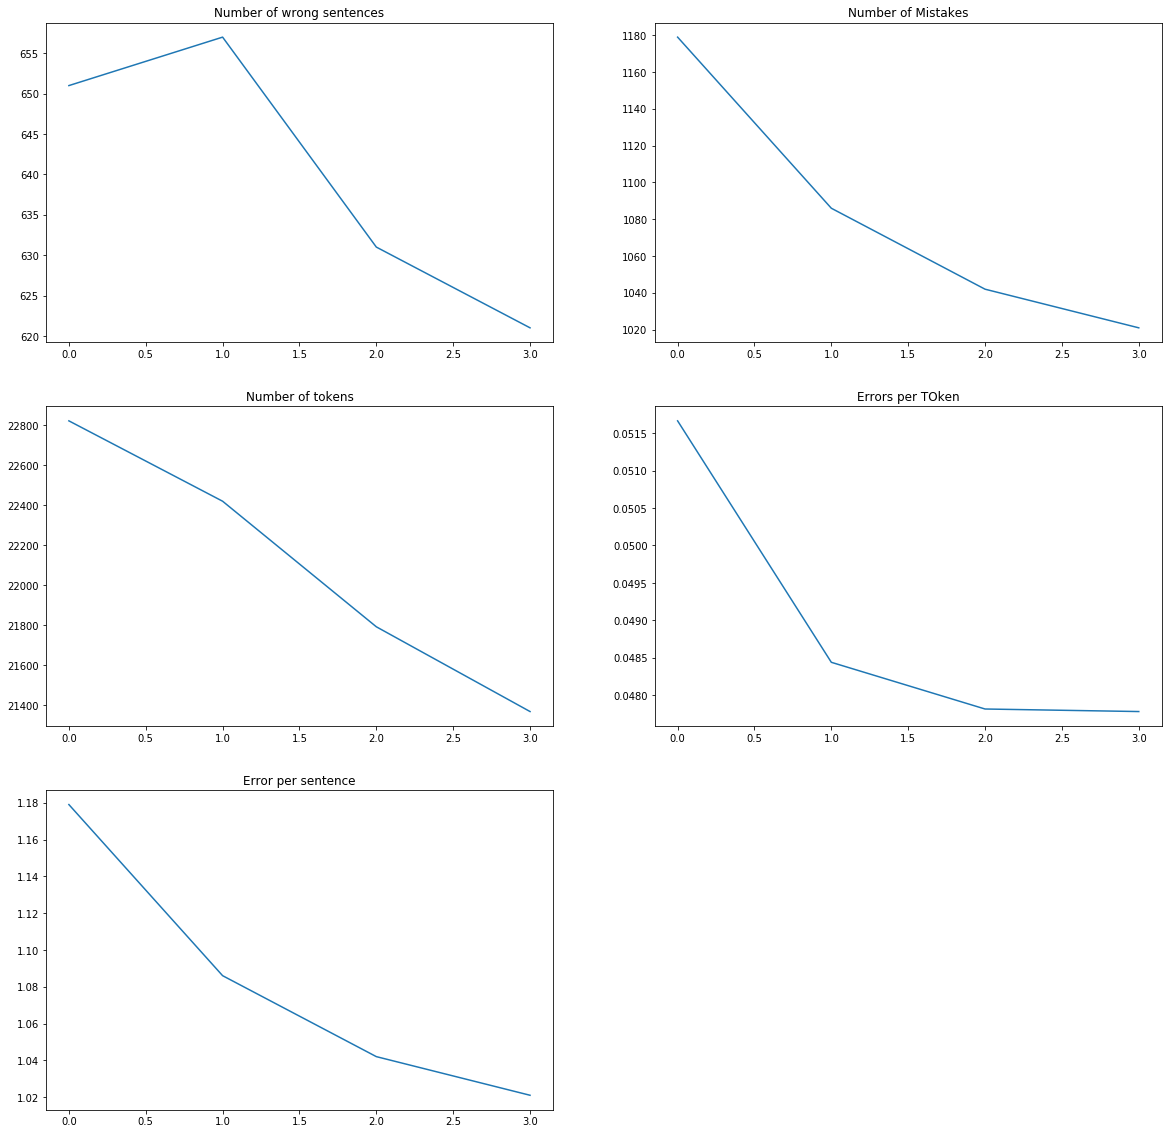

In [66]:
out = out.T
plt.figure(figsize=(20,20))
for x in range(len(titles)):
    plt.subplot(int(str(32) + str(x+1)))
    plt.title(titles[x])
    plt.plot(out[x])


In [ ]:
titles = ["Number of wrong sentences", "Number of Mistakes", "Number of tokens", "Errors per TOken","Error per sentence"]

In [38]:
%%capture
out = grammar_stats(finalC[-1],finalS[-1])

In [45]:
out = np.array(out)

In [48]:
out[0]

[('MORFOLOGIK_RULE_EN_US', 712),
 ('EN_UNPAIRED_BRACKETS', 216),
 ('SENTENCE_FRAGMENT', 12),
 ('COMMA_PARENTHESIS_WHITESPACE', 8),
 ('ENGLISH_WORD_REPEAT_RULE', 8),
 ('A_INFINITVE', 7),
 ('A_PLURAL', 4),
 ('POSSESSIVE_APOSTROPHE', 4),
 ('EN_A_VS_AN', 3),
 ('HE_VERB_AGR', 3),
 ('THE_SUPERLATIVE', 3),
 ('CD_NN', 3),
 ('NO_SPACE_CLOSING_QUOTE', 3),
 ('MANY_NN', 2),
 ('THERE_RE_MANY', 2),
 ('I_LOWERCASE', 2),
 ('UPPERCASE_SENTENCE_START', 2),
 ('SENT_START_CONJUNCTIVE_LINKING_ADVERB_COMMA', 2),
 ('BEEN_PART_AGREEMENT', 1),
 ('AFFECT_EFFECT', 1),
 ('DT_PRP', 1),
 ('EN_QUOTES', 1),
 ('MAN_MEN', 1),
 ('HE_THE', 1),
 ('NON3PRS_VERB', 1),
 ('ONE_PLURAL', 1),
 ('DATE_WEEKDAY', 1),
 ('EVERYDAY_EVERY_DAY', 1),
 ('THIS_NNS', 1),
 ('PRP_RB_NO_VB', 1),
 ('SOME_OF_THE', 1),
 ('ADVERB_WORD_ORDER', 1),
 ('WHOS_NN', 1),
 ('DID_BASEFORM', 1),
 ('KNEW_NEW', 1),
 ('IN_A_X_MANNER', 1),
 ('THE_PUNCT', 1),
 ('PROGRESSIVE_VERBS', 1),
 ('ALLY_ALLAY', 1),
 ('ANY_MORE', 1),
 ('SOME_NN_VBP', 1),
 ('AFFORD_VB', 1),


In [ ]:
a = load_dream_6_train(13)

In [103]:
stats = results_the_dream(a,0).T


0
1
2
3
4
5
6
7
8
9
10
11
12


In [106]:
pickle.dump(stats,open("6Dream_train_stats.p","wb"))

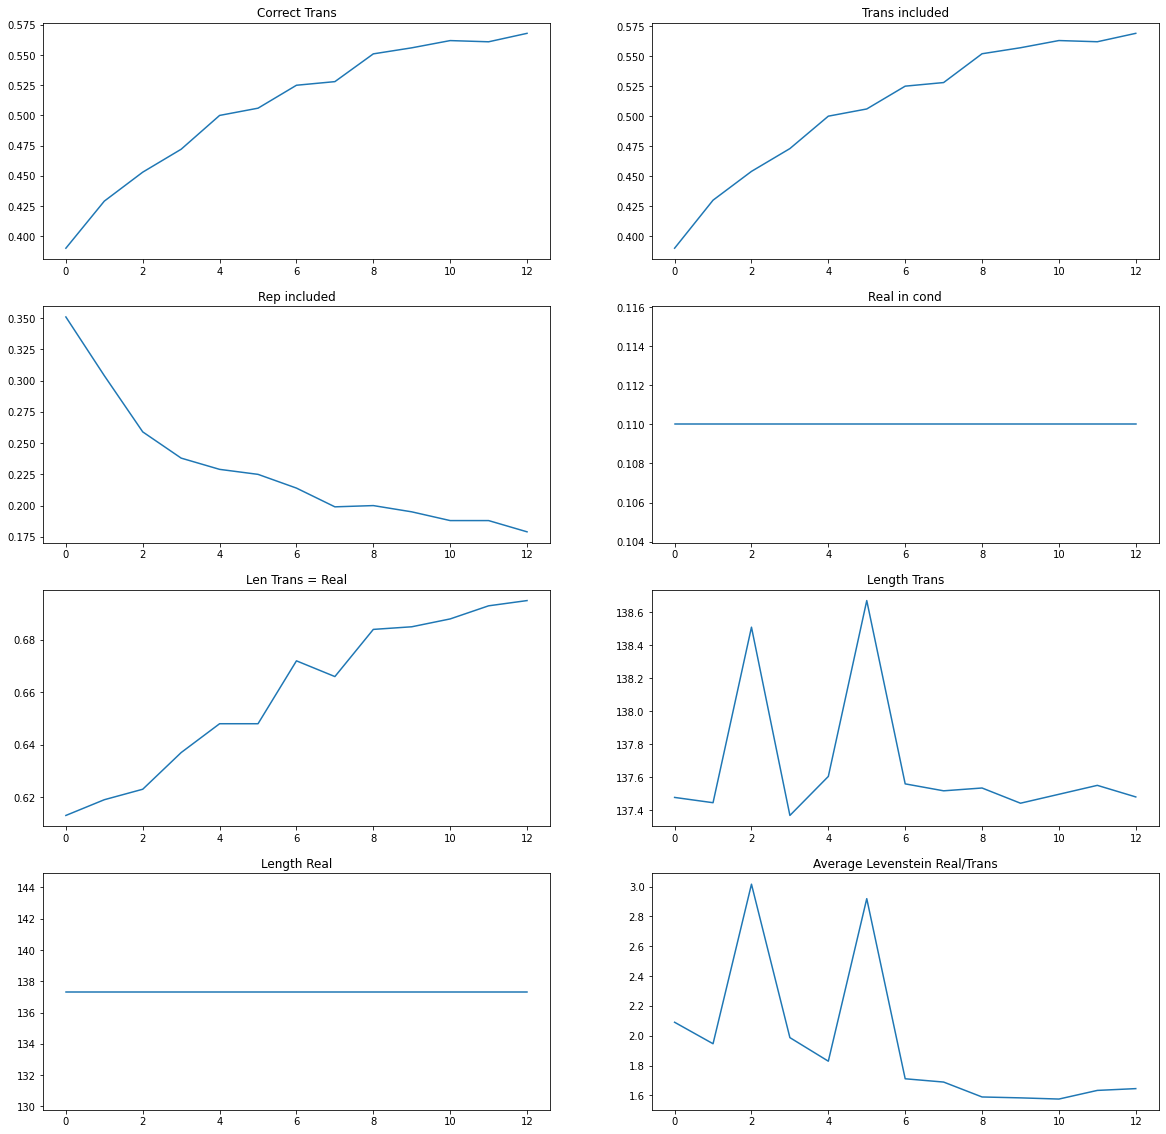

In [107]:
titles = ["Correct Trans","Trans included", "Rep included","Real in cond","Len Trans = Real","Length Trans","Length Real","Average Levenstein Real/Trans"]

plt.figure(figsize=(20,20))

for x in range(len(titles)):
    
    plt.subplot(int(str(42) + str(x+1)))
    plt.title(titles[x])
    plt.plot(stats[x])



In [108]:
b = load_dream_6_test(13)

In [ ]:
stats_T = results_the_dream(b,1).T

0


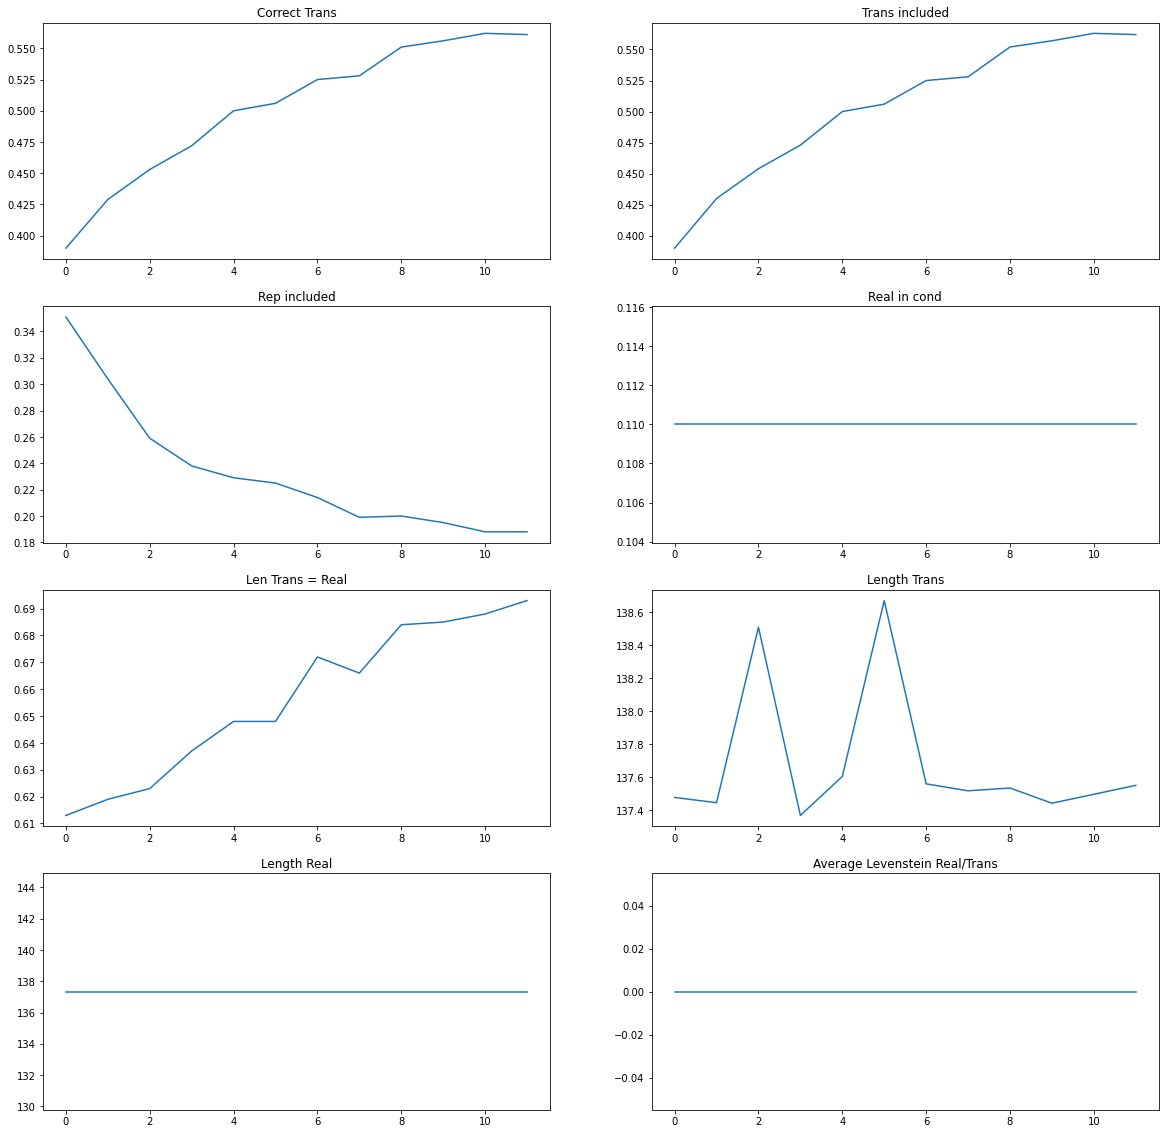

In [93]:
titles = ["Correct Trans","Trans included", "Rep included","Real in cond","Len Trans = Real","Length Trans","Length Real","Average Levenstein Real/Trans"]

plt.figure(figsize=(20,20))

for x in range(len(titles)):
    
    plt.subplot(int(str(42) + str(x+1)))
    plt.title(titles[x])
    plt.plot(stats_T[x])

